In this notebook, we will learn how to use the ImgLib2 cache library to implement lazy processing workflows at the level of cells (blocks, chunks, boxes, hyperrectangles, Intervals).  To make things a bit easier, we will compile and install a small helper library with useful functions.  You can find it in `/i2k2024-lazy-spark`.  Please build it:
```
mvn clean package
```
Great!  We can now add this as a dependency, together with everything else that we will use:

In [1]:
%mavenRepo scijava.public https://maven.scijava.org/content/groups/public
%maven org.scijava:scijava-common:2.99.0
%maven mpicbg:mpicbg_:1.5.0
%maven net.imglib2:imglib2:7.1.2
%maven net.imglib2:imglib2-realtransform:4.0.3
%maven net.imglib2:imglib2-ij:2.0.3
%maven org.janelia.saalfeldlab:n5-ij:4.2.5
%maven sc.fiji:bigdataviewer-core:10.6.2
%maven net.haesleinhuepf:clij2_:2.5.3.1
%jars ../../i2k2024-lazy-spark/target/i2k-2024-lazy-spark-0.0.1-SNAPSHOT.jar

In [2]:
import bdv.cache.SharedQueue;
import bdv.util.*;
import bdv.util.volatiles.VolatileViews;
import ij.ImagePlus;
import io.github.spencerpark.jupyter.kernel.display.common.*;
import io.github.spencerpark.jupyter.kernel.display.mime.*;
import mpicbg.ij.clahe.Flat;
import mpicbg.ij.plugin.NormalizeLocalContrast;
import net.imglib2.*;
import net.imglib2.algorithm.lazy.*;
import net.imglib2.cache.img.*;
import net.imglib2.converter.*;
import net.imglib2.img.display.imagej.*;
import net.imglib2.type.numeric.*;
import net.imglib2.type.numeric.integer.*;
import net.imglib2.type.numeric.real.*;
import net.imglib2.util.*;
import net.imglib2.view.*;
import org.janelia.saalfeldlab.i2k2024.*;
import org.janelia.saalfeldlab.i2k2024.ops.*;
import org.janelia.saalfeldlab.i2k2024.util.*;
import org.janelia.saalfeldlab.n5.*;
import org.janelia.saalfeldlab.n5.imglib2.N5Utils;
import org.janelia.saalfeldlab.n5.universe.N5Factory;

As before, we register image renderers, so we can see soemthing in the notebook.

In [3]:
//| code-fold: true

getKernelInstance().getRenderer().createRegistration(RandomAccessibleInterval.class)
    .preferring(MIMEType.IMAGE_PNG)
    .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
    .register((rai, context) -> Image.renderImage(
        ImageJFunctions.wrap(rai, rai.toString()).getBufferedImage(),
        context));

Let's first define a source:

In [4]:
var n5Url = "https://janelia-cosem.s3.amazonaws.com/jrc_hela-2/jrc_hela-2.n5";
var n5Dataset = "/em/fibsem-uint16/s3";

final var n5 = new N5Factory().openReader(n5Url);
final RandomAccessibleInterval<UnsignedShortType> img = N5Utils.openVolatile(n5, n5Dataset);

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


For processing, we will use ImgLib2 cached cell loaders.  This is best done with a shared factory:

In [5]:
/* create a cached image factory with reasonable default values */
final var cacheFactory = new ReadOnlyCachedCellImgFactory(
  new ReadOnlyCachedCellImgOptions()
      .volatileAccesses(true)         //< use volatile accesses for display
      .cellDimensions(256, 256, 32)); //< standard block size for this example

Now some parameters:

In [6]:
int scaleIndex = 3;
final double scale = 1.0 / Math.pow(2, scaleIndex);
final int blockRadius = (int)Math.round(1023 * scale);

Let's create our first lazy processed image:

In [7]:
/* Use the ImageJ CLAHE plugin in an op to produce CLAHE enhanced cells */
final var clahe = new ImageJStackOp<>(
    Views.extendMirrorSingle(img),
    fp -> Flat.getFastInstance().run(
        new ImagePlus("", fp),
        blockRadius,
        256,
        3.0f,
        null,
        false),
    blockRadius,
    0,
    65535);

/* create a lazy-generating cached cell image using the clahe op as a cell loader */
final var clahed = cacheFactory.create(
    img.dimensionsAsLongArray(),               //< the size of the result
    img.randomAccess().get().createVariable(), //< the type that is used to generate the result pixels
    clahe::accept);                            //< the consumer that creates each cell

Let's look at `clahed`:

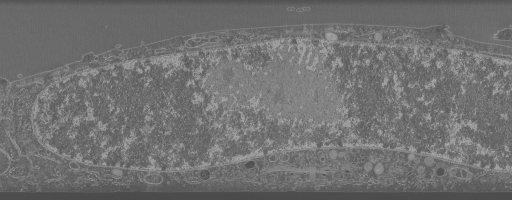

In [8]:
var clahedCrop = clahed.view().interval(
    Intervals.createMinSize(
        clahed.dimension(2) / 2, 0, clahed.dimension(2) / 2,
        512, clahed.dimension(1), 1));
clahedCrop;

In [9]:
/* Use the ImageJ plugin local contrast normalization in an op to produce contrast enhanced cells */
final var lcn =
    new ImageJStackOp<UnsignedShortType>(
        Views.extendMirrorSingle(img),
        fp -> NormalizeLocalContrast.run(
            fp,
            blockRadius,
            blockRadius,
            3f,
            true,
            true),
        blockRadius,
        0,
        65535);

/* create a lazy-generating cached cell image using the lcn op as a cell loader */
final var lcned = cacheFactory.create(
    img.dimensionsAsLongArray(),               //< the size of the result
    img.randomAccess().get().createVariable(), //< the type that is used to generate the result pixels
    lcn::accept);                              //< the consumer that creates each cell

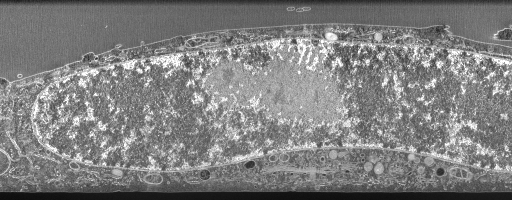

In [10]:
var lcnedCrop = lcned.view().interval(clahedCrop);
lcnedCrop;

In [11]:
/* Use the new ImageJ plugin contrast limited local contrast normalization in an op to produce contrast enhanced cells */
final var cllcn =
    new ImageJStackOp<UnsignedShortType>(
        Views.extendMirrorSingle(img),
        fp -> new CLLCN(fp).run(
            blockRadius,
            blockRadius,
            3f,
            10,
            0.5f,
            true,
            true,
            true),
        blockRadius,
        0,
        65535);

/* create a lazy-generating cached cell image using the cllcn op as a cell loader */
final var cllcned = cacheFactory.create(
    img.dimensionsAsLongArray(),               //< the size of the result
    img.randomAccess().get().createVariable(), //< the type that is used to generate the result pixels
    cllcn::accept);                            //< the consumer that creates each cell

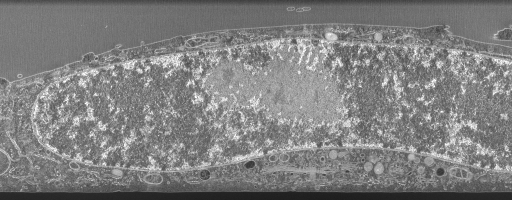

In [12]:
var cllcnedCrop = cllcned.view().interval(clahedCrop);
cllcnedCrop;

In [13]:
/* Invert and float convert the image, then use the CLIJ2 DoG filter */
final var inverted =
    Converters.convert(img, (a, b) -> b.setReal(0xffff - a.getRealDouble()), new FloatType());
final var clij2Filter =
    new CLIJ2FilterOp<FloatType, FloatType>(
        Views.extendMirrorSingle(inverted), 20, 20, 20);
    clij2Filter.setFilter(
        (a, b) -> clij2Filter.getClij2().differenceOfGaussian(a, b, 4, 4, 4, 3, 3, 3));
final var clij2filtered = cacheFactory.create(
    img.dimensionsAsLongArray(), //< the size of the result
    new FloatType(),             //< the type that is used to generate the result pixels
    clij2Filter::accept,         //< the consumer that creates each cell
    new ReadOnlyCachedCellImgOptions().cellDimensions(64, 64, 64));

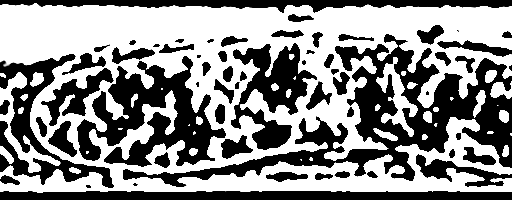

In [14]:
var clij2filteredCrop = clij2filtered.view().interval(clahedCrop);
clij2filteredCrop;

All this felt a bit non-interactive, so let's see how it looks in BigDataViewer:

In [15]:
final var queue = new SharedQueue(Math.max(1, Runtime.getRuntime().availableProcessors() - 1));

BdvStackSource<?> bdv = null;

bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(
        img,
        queue),
    n5Dataset,
    BdvOptions.options());
bdv.setDisplayRange(10000, 50000);

In [16]:
bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(
        clahed,
        queue),
    n5Dataset + " CLAHE",
    BdvOptions.options().addTo(bdv));
bdv.setDisplayRange(10000, 50000);

In [17]:
bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(
        lcned,
        queue),
    n5Dataset + " LCN",
    BdvOptions.options().addTo(bdv));
bdv.setDisplayRange(10000, 50000);

In [18]:
bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(
        cllcned,
        queue),
    n5Dataset + " CLLCN",
    BdvOptions.options().addTo(bdv));
bdv.setDisplayRange(10000, 50000);

In [19]:
bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(
        clij2filtered,
        queue),
    n5Dataset + " CLIJ2 DoG",
    BdvOptions.options().addTo(bdv));
bdv.setDisplayRange(-1000, 1000);

Gradients of CLAHE enhanced image:

In [20]:
/* convert to a signed type that can capture the gradients */
final var imgDoubles = Converters.convert(
    clahed,
    (a, b) -> b.setReal(a.getRealDouble()),
    new DoubleType());

/* gradients X */
final var gradientX = Functions.centerGradientRAI(imgDoubles, 0);
/* gradients Y */
final var gradientY = Functions.centerGradientRAI(imgDoubles, 1);
/* gradients Z */
final var gradientZ = Functions.centerGradientRAI(imgDoubles, 2);

/* cache results */
var cachedGradientX = Caches.cache(gradientX, 16, 16, 16);
var cachedGradientY = Caches.cache(gradientY, 16, 16, 16);
var cachedGradientZ = Caches.cache(gradientZ, 16, 16, 16);

bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(cachedGradientX),
    n5Dataset + " CLAHE gradient x",
BdvOptions.options().addTo(bdv));
bdv.setColor(new ARGBType(0xffff0000));
bdv.setDisplayRange(-4000, 4000);

bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(cachedGradientY),
    n5Dataset + " CLAHE gradient y",
    BdvOptions.options().addTo(bdv));
bdv.setColor(new ARGBType(0xff00ff00));
bdv.setDisplayRange(-4000, 4000);

bdv = BdvFunctions.show(
    VolatileViews.wrapAsVolatile(cachedGradientZ),
    n5Dataset + " CLAHE gradient z",
    BdvOptions.options().addTo(bdv));
bdv.setColor(new ARGBType(0xff0000ff));
bdv.setDisplayRange(-4000, 4000);

We've now interactively inspected the results of our operation, and would like to process the entire dataset and save the output.  Since saving requires that the data exists, we can simply save the incomplete lazy-cached result in parallel.  This will trigger evaluation where data has not been generated:  

In [21]:
final var n5OutUrl = "/home/saalfeld/tmp/jrc_hela-2.zarr";
final var n5OutGroup = "/em/fibsem-uint16/processed/";

/* use the same attributes as source */
var attributes = n5.getDatasetAttributes(n5Dataset);

/* create an N5 factory with reasonable defaults */
final N5Factory n5Factory = new N5Factory()
    .zarrDimensionSeparator("/");

/* working in parallel helps */
final var exec = Executors.newFixedThreadPool(12);

display("Processing...");

final var timer = new org.janelia.saalfeldlab.i2k2024.util.Timer();
timer.start();

try (final N5Writer n5Out = n5Factory.openWriter(n5OutUrl)) {
  N5Utils.save(
    cachedGradientX,
    n5Out,
    n5OutGroup + "clahe-gradient-x",
    attributes.getBlockSize(),
    attributes.getCompression(),
    exec);
    
  display("... x done in " + timer.stop() + "ms.");
  timer.start();

  N5Utils.save(
    cachedGradientY,
    n5Out,
    n5OutGroup + "clahe-gradient-y",
    attributes.getBlockSize(),
    attributes.getCompression(),
    exec);

  display("... y done in " + timer.stop() + "ms.");
  timer.start();

  N5Utils.save(
    cachedGradientZ,
    n5Out,
    n5OutGroup + "clahe-gradient-z",
    attributes.getBlockSize(),
    attributes.getCompression(),
    exec);

  display("... z done in " + timer.stop() + "ms.");
  timer.start();
}

exec.shutdown();

Processing...

... x done in 96666.228947ms.

... y done in 21813.889825ms.

... z done in 21835.305614ms.